## Bengali to English translation

**Problem statement:**

To create a seq2seq model that can translate **Bengali sentence to English.**

Sequence to Sequence (often abbreviated to seq2seq) models are a special class of Recurrent Neural Network architectures typically used (but not restricted) to solve complex Language related problems like Machine Translation. In this project, we will try to translate a text from Bengali to English.

The seq2seq models is normally composed of an encoder-decoder architecture, where the encoder processes the input sequence and encodes/compresses/summarizes the information into a context vector (also called as the “thought vector”) of a fixed length. The decoder is then initialized with this context vector, using which it starts generating the transformed output.

But A critical and apparent disadvantage of this fixed-length context vector design is the incapability of the system to remember longer sequences. Often is has forgotten the earlier parts of the sequence once it has processed the entire the sequence. So we will use attention mechanism to resolve this problem.

The dataset was downloaded from <a href='http://www.manythings.org/anki/'>here</a>

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    #w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
en_sentence = u"May I borrow this book?"
bn_sentence = u"আমি কেক খেতে ভালোবাসি।"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(bn_sentence))

<start> may i borrow this book ? <end>
<start> আমি কেক খেতে ভালোবাসি। <end>


In [ ]:
s = "123mango abcd mango kiwi peach"
s.split(" ", 2)  #here '2' is the number of delimiters for split

['123mango', 'abcd', 'mango kiwi peach']

In [ ]:
s.split(" ", 2)[:2]

['123mango', 'abcd']

In [5]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t',2)[:2]]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [6]:
path_to_file = '/content/drive/MyDrive/dataset_colab/ben.txt'

In [7]:
en, bn = create_dataset(path_to_file, None)
print(en[-1])
print(bn[-1])

<start> i thought doing this would be easy , but we've been working all day and we're still not finished . <end>
<start> আমি ভেবেছিলাম এটা করা সহজ হবে , কিনত আমরা সারাদিন ধরে কাজ করেছি আর এখনো শেষ করে উঠতে পারিনি। <end>


In [10]:
print(len(en), len(bn))

4332 4332


In [8]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [9]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to 4000 lines

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [11]:
# Try experimenting with the size of that dataset
num_examples = 4000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [1]:
#inp_lang.word_index

In [19]:
sentence = 'আমি ভেবেছিলাম এটা করা সহজ হবে , কিনত আমরা সারাদিন ধরে কাজ করেছি আর এখনো শেষ করে উঠতে পারিনি।'

[inp_lang.word_index[i] for i in sentence.split(' ') if i in inp_lang.word_index]

[4,
 696,
 10,
 90,
 1187,
 221,
 61,
 575,
 17,
 914,
 410,
 82,
 924,
 54,
 74,
 228,
 16,
 806]

In [12]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

3200 3200 800 800


In [13]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [14]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
2763 ----> আরবী
29 ----> খব
460 ----> গরতবপরণ
2764 ----> ভাষা।
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
1608 ----> arabic
8 ----> is
11 ----> a
48 ----> very
368 ----> important
279 ----> language
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 13]), TensorShape([64, 14]))

## Write the encoder and decoder model

This tutorial uses Attention model for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

## Encoder Model

In [20]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [21]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 13, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


## Attention Model

In [22]:
class Attention_model(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [23]:
attention_layer = Attention_model(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 13, 1)


## Decoder

In [24]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = Attention_model(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [25]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 1645)


## Define the optimizer and the loss function

In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [32]:
checkpoint_dir = '/content/drive/MyDrive/dataset_colab/Untitled Folder'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [34]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += loss_function(targ[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [35]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.1237
Epoch 1 Loss 2.0660
Time taken for 1 epoch 18.53712749481201 sec

Epoch 2 Batch 0 Loss 1.4469
Epoch 2 Loss 1.4637
Time taken for 1 epoch 4.5958781242370605 sec

Epoch 3 Batch 0 Loss 1.2056
Epoch 3 Loss 1.2115
Time taken for 1 epoch 3.918592691421509 sec

Epoch 4 Batch 0 Loss 1.0937
Epoch 4 Loss 0.9957
Time taken for 1 epoch 4.563145875930786 sec

Epoch 5 Batch 0 Loss 0.8769
Epoch 5 Loss 0.7970
Time taken for 1 epoch 4.0197319984436035 sec

Epoch 6 Batch 0 Loss 0.6728
Epoch 6 Loss 0.6202
Time taken for 1 epoch 4.725351333618164 sec

Epoch 7 Batch 0 Loss 0.4013
Epoch 7 Loss 0.4690
Time taken for 1 epoch 3.9753878116607666 sec

Epoch 8 Batch 0 Loss 0.3720
Epoch 8 Loss 0.3534
Time taken for 1 epoch 4.690484285354614 sec

Epoch 9 Batch 0 Loss 0.1996
Epoch 9 Loss 0.2688
Time taken for 1 epoch 4.0374672412872314 sec

Epoch 10 Batch 0 Loss 0.2000
Epoch 10 Loss 0.1973
Time taken for 1 epoch 5.09757661819458 sec

Epoch 11 Batch 0 Loss 0.1924
Epoch 11 Loss 0.1480
Time 

## Translate

* The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [36]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ') if i in inp_lang.word_index ]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [27]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [28]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [37]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> টম ফরাসি পডতে পারে। <end>
Predicted translation: tom can read french . <end> 


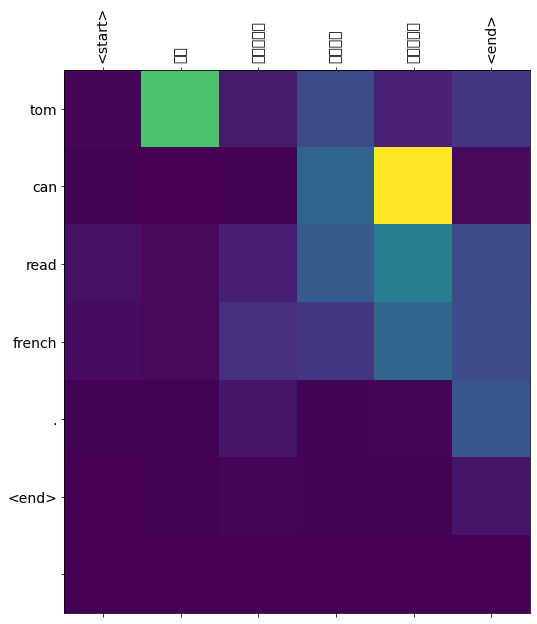

In [49]:
#translate(u'hace mucho frio aqui.')
translate(u'টম ফরাসি পড়তে পারে।')

Input: <start> আমর কফি ভালো লাগে না। <end>
Predicted translation: i don't like coffee . <end> 


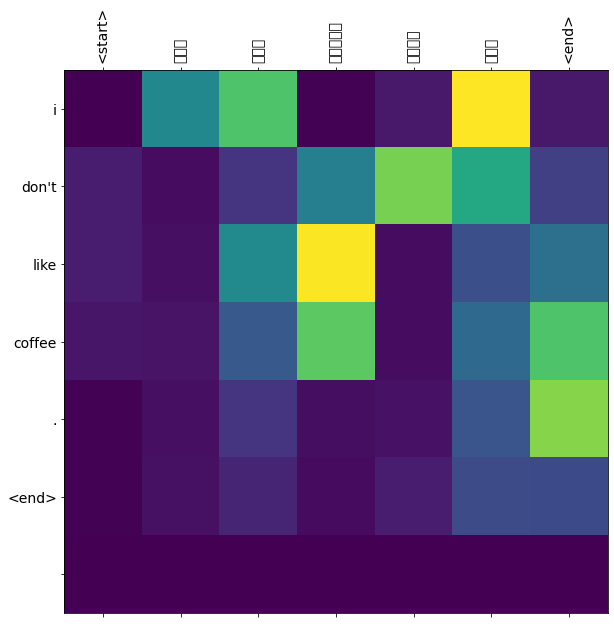

In [48]:
translate(u'আমর কফি ভালো লাগে না।')

Input: <start> আমাকে চেডে দাও। <end>
Predicted translation: leave me . <end> 


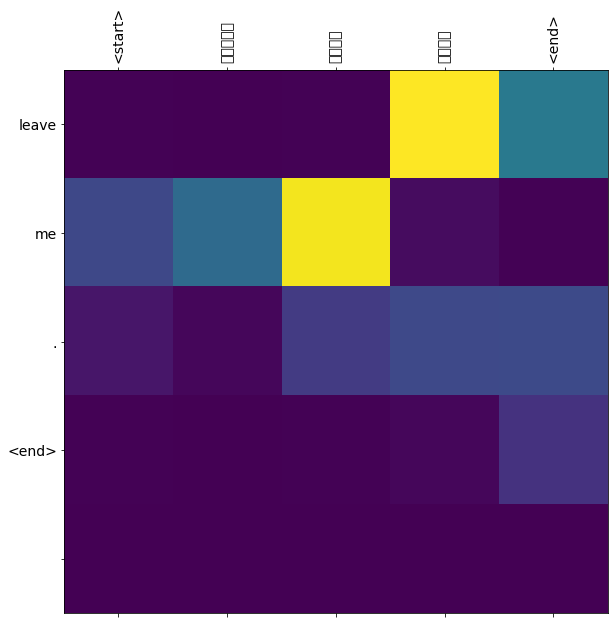

In [40]:
translate(u'আমাকে চেড়ে দাও।')

Input: <start> করীসটমাস আর কযেকদিন দরে। <end>
Predicted translation: christmas is just a few days away . <end> 


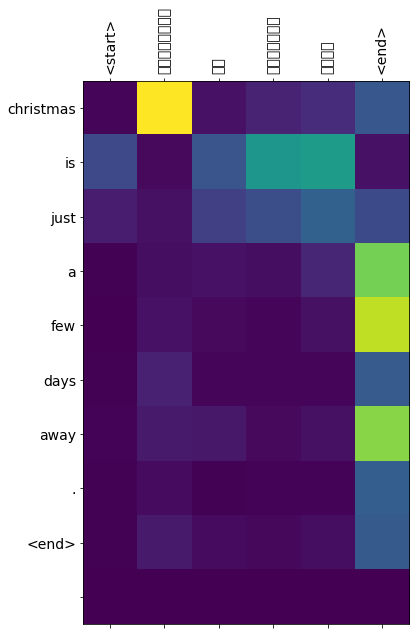

In [43]:
translate(u'ক্রীস্টমাস আর কয়েকদিন দূরে।')

Input: <start> তোমার একা একা জঙগলে যাওযা উচিত হয নি। <end>
Predicted translation: don't like . <end> 


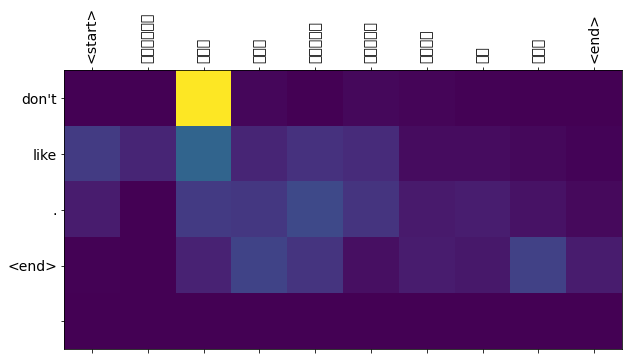

In [50]:
translate(u'তোমার একা একা জঙ্গলে যাওয়া উচিত হয় নি।')

## Next step

Experiment with training on a larger dataset, or using more epochs